# Slimming down cleaning process and make it able to take in any new data
##### Started 14.12.22

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import string
import re
import json
import ast
from collections import Counter
import statistics as stats
import matplotlib.pyplot as plt

### Getting workable DF

In [2]:
data_path = '~/code/emilycardwell/final-project-data/data/raw/kaggle_raw.csv'
raw_df = pd.read_csv(data_path)
slim_raw_df = raw_df[['artist_name', 'song_name', 'chords', 'genres', 'popularity']]
slim_raw_df.head(3)

,artist_name,song_name,chords,genres,popularity
0,Justin Bieber,"10,000 Hours",{3: 'G G/B ...,"['canadian pop', 'pop', 'post-teen pop']",100
1,Justin Bieber,2 Much,"{1: 'Intro: F#m7 D2 ', 4: 'F#m7 ', 8: 'D2 ', ...","['canadian pop', 'pop', 'post-teen pop']",100
2,Justin Bieber,2u (feat. David Guetta),{1: 'Em D C C...,"['canadian pop', 'pop', 'post-teen pop']",100


In [3]:
first_raw = ast.literal_eval(slim_raw_df.loc[0, 'chords'])
first_raw

{3: 'G             G/B                         C ',
 5: '                  G ',
 7: 'G                  G/B                         C ',
 9: '                G ',
 13: '         G         Em             C       G     ',
 15: '     G        Em                C   G ',
 19: '          G            Em        C            G    ',
 21: '      G              Em                  C              G    ',
 23: '      G           Em             C         G    ',
 25: '        G            Em           C          G    ',
 27: '           G        Em       C        G            ',
 31: 'G             G/B                       C ',
 33: '                 G ',
 35: 'G                G/B                C        ',
 37: '                G ',
 41: '         G         Em             C       G     ',
 43: '     G        Em                C   G ',
 47: '          G            Em        C            G    ',
 49: '      G              Em                  C              G    ',
 51: '      G           Em       

## Data Exploration

the song is 35 measures long.
the first 4 lines of chords are:
G-------------G/B-------------------------C-
(length: 44)
------------------G-
(length: 20)
G------------------G/B-------------------------C-
(length: 49)
----------------G-
(length: 18)


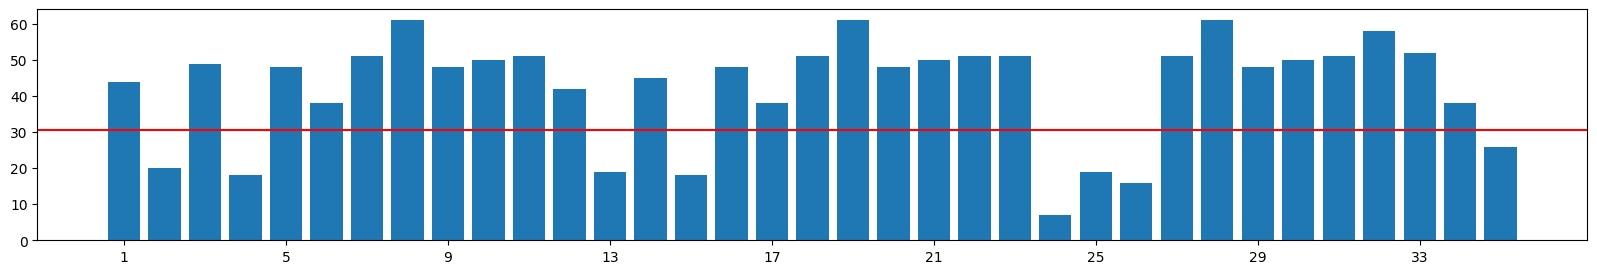

In [4]:
song_ch_lol = []
i = 0

song1 = slim_raw_df.chords[0]

song_mm_ch_dict = ast.literal_eval(song1)
song_ch_lol = [ch for ch in song_mm_ch_dict.values()]
max_line = len(song_ch_lol)

print(f'the song is {max_line} measures long.')
print('the first 4 lines of chords are:')
for ch in song_ch_lol:
    new = ch.replace(" ", "-")
    print(new)
    l = len(new)
    print(f'(length: {l})')
    i += 1
    if i == 4: break

# get line lengths
line_lens = [len(x) for x in song_ch_lol]
max_line_len = max(line_lens)

# {measure_no: chords_list}: dict
measures = [x for x in range(1, len(song_ch_lol)+1)]

fig1, ax1 = plt.subplots(figsize=(20,3))
ax1.axhline(max_line_len/2, color='red')
ax1.bar(measures, line_lens)
xt = np.arange(1, max_line+1, 4)
ax1.set(xticks=xt, xticklabels=xt)
plt.show()

#### See Chord Frequency

In [5]:
chords_ser_raw = slim_raw_df.chords.copy()

chords_ser_lists = pd.Series(index=range(len(slim_raw_df)), dtype='object')

for i, song in enumerate(chords_ser_raw):
    song_mm_ch_dict = ast.literal_eval(song)
    song_ch_lol = [ch for ch in song_mm_ch_dict.values()]
    chords_ser_lists.iloc[i] = song_ch_lol

chords_ser_lists.head()

0    [G             G/B                         C ,...
1    [Intro: F#m7  D2 , F#m7 , D2 , F#m7 ,         ...
2    [Em            D         C               C  D ...
3    [ Intro: Em  Bm  Am  C   (2x) ,           Em  ...
4    [Intro: Gm - Dm - C - C   x2 ,        Gm      ...
dtype: object

In [7]:
chords_counter = Counter()
for song in chords_ser_lists:
    for line in song:
        l = line.split(' ')
        chords_counter.update(l)
del chords_counter['']

chord_count_df = pd.Series(dict(chords_counter)).to_frame('chord_count')
sorted_cc_df = chord_count_df.sort_values(by='chord_count', ascending=False)
print('the total amount of unique "chords" is: ', len(sorted_cc_df))

the total amount of unique "chords" is:  103294


In [ ]:
# pd.options.display.max_rows = 100
# sorted_cc_df.head(100)

In [8]:
letters = list(string.ascii_uppercase)[:7]
non_chord_filter = [chord for chord in sorted_cc_df.index if chord[0] in letters]
filtered_cc_df = sorted_cc_df[sorted_cc_df.index.isin(non_chord_filter)]
print('the total amount of unique "chords" is: ', len(filtered_cc_df))

the total amount of unique "chords" is:  77872


In [11]:
# pd.set_option('display.max_rows', 200)
# filtered_cc_df.iloc[0:200]

In [ ]:
# slim_chord_counts_dict = {}
# for chord, count in chords_count_dict.items():
#     if count <= low_freq_to_remove:
#         pass
#     else:
#         slim_chord_counts_dict[chord] = count

## Cleaning

### Test

In [48]:
# editing repeats
test_chords = 'Intro: Gm - Dm - C - C   x2 Gm7   F % Csus4/D'
chords_wo_reps = ''

# find repeat symbols (%, - , x2, 2x) and replace with preceding chord
if re.findall(r'%|2x|x2|\s-\s', test_chords):
    reps = re.findall(r'(\S+)(?=\s*(%|2x|x2|\s-\s))|([A-Z]\S+)', test_chords)
    for x in reps:
        if x[0] != '':
            chords_wo_reps += x[0] + ' ' + x[0] + ' '
        else:
            chords_wo_reps += x[2] + ' '
else:
    chords_wo_reps = test_chords
print(test_chords)
print(chords_wo_reps)

Intro: Gm - Dm - C - C   x2 Gm7   F % Csus4/D
Intro: Gm Gm Dm Dm C C C C Gm7 F F Csus4/D 


In [164]:
# cleaning up chords
test2_chords = '      Intro: G-F-G  FMm7,    G\\F\\F\\F,       Amsus6 GM7/D#   (F3)    BbFbCG     '

# remove non-useful punctuation
no_punc_ch = re.sub(r'-+|[()|,.]|\\', ' ', test2_chords)

# remove spaces
mult_sp_rem_ch = re.sub(r'\s+', ' ', no_punc_ch)
beg_sp_rem_ch = re.sub(r'^\s+', '', mult_sp_rem_ch)
end_sp_rem_ch = re.sub(r'\s+$', '', beg_sp_rem_ch)
    
end_sp_rem_ch

'Intro: G F G FMm7 G F F F Amsus6 GM7/D# F3 BbFbCG'

### Clean DF

In [24]:
cleaned_chords_ser = pd.Series(index=range(len(chords_ser_lists)), dtype='object')
raw_chords_ser = chords_ser_lists[0:100].copy()
raw_chords_ser[4]

['Intro: Gm - Dm - C - C   x2 ',
 '       Gm              Dm ',
 '      C                C ',
 '    Gm                      Dm       ',
 '     C                C ',
 ' Gm                        A#          C* ',
 '          Gm ',
 '        A#              C* ',
 '              Gm                      A#      C* ',
 '         Gm                                         A#    C* ',
 'B|-----------11----11--------------6---6-------------8---8--------8--------8------| ',
 'G|--------12----------12---------7-------7---------9-------9--------9--------9----| ',
 'D|-----12----------------12----7-----------7----10-----------10-------10-------10-| ',
 'A|--10-----------------------5---------------10-----------------------------------| ',
 'E|--------------------------------------------------------------------------------| ',
 'B|-----------11----11--------------6---6-------------8---8--------8--------8------| ',
 'G|--------12----------12---------7-------7---------9-------9--------9--------9----

In [25]:
for i, song in enumerate(raw_chords_ser):
    
    cleaned_song = ''
    j = 0
    for line in song:
        # remove bar charts, repeat symbols (%, - , x2, 2x), non-useful punctuation, non-useful characters, and phrasing words
        re_expression0 = r'\S[|]\S+'
        re_expression1 = r'-+|[()|,.]|\\|~|:|%|2x|x2|\s-\s|\s[0-9]+|\b[H-Zh-z]\w*|Br\w*'
        re_expression2 = r'\s/\w*'
        re_expression3 = r'(?<!\s)/(?=[0-9])'
        cleaned_string0 = re.sub(re_expression0, ' ', line)
        cleaned_string1 = re.sub(re_expression1, ' ', cleaned_string0)
        cleaned_string2 = re.sub(re_expression2, ' ', cleaned_string1)
        cleaned_string3 = re.sub(re_expression3, '', cleaned_string2)

        # remove multiple spaces
        mult_sp_rem_ch = re.sub(r'\s+', ' ', cleaned_string3)
        beg_end_sp_rem_song = re.sub(r'^\s+|\s+$', '', mult_sp_rem_ch)

        if j < len(song)-1:
            cleaned_song += beg_end_sp_rem_song + ' '
            j += 1
        else:
            cleaned_song += beg_end_sp_rem_song
            
    cleaned_chords_ser.iloc[i] = cleaned_song
    
cleaned_chords_ser.head()

0    G G/B C G G G/B C G G Em C G G Em C G G Em C G...
1    F# D2 F# D2 F# D2 E F# A/C# E D2 E F# Bm A/C# ...
2    Em D C C D Em Em D C C D Em Em D C Am D Em G C...
3    Em Bm Am C Em Bm Am C Em Bm Am C Bm Em Bm Am C...
4    Gm Dm C C Gm Dm C C Gm Dm C C Gm A# C* Gm A# C...
dtype: object

In [13]:
cleaned_chords_counter = Counter()
for song in cleaned_chords_ser:
    l = song.split(' ')
    cleaned_chords_counter.update(l)
del cleaned_chords_counter['']

cleaned_chord_count_df = pd.Series(dict(cleaned_chords_counter)).to_frame('chord_count')
cleaned_cc_df = cleaned_chord_count_df.sort_values(by='chord_count', ascending=False)
print('the total amount of unique "chords" is: ', len(cleaned_cc_df))
# cleaned_cc_df.head(100)

the total amount of unique "chords" is:  92081


In [237]:
cleaned_cc_df[100:200]

,chord_count
Dmaj7,6205
D7/9,6193
G/F#,6151
E7/9,6113
Edim,6108
A6,6052
Bbm7,5708
F7+,5596
C7+,5459
Gmaj7,5423


In [ ]:
letters = list(string.ascii_uppercase)[:7]
non_chord_filter = [chord for chord in sorted_cc_df.index if chord[0] in letters]
cc_df = sorted_cc_df[sorted_cc_df.index.isin(non_chord_filter)]
cc_df.iloc[100:200]

## Creating List of Correctly Formatted Chords

In [ ]:
major_chords = ['C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'F', 'F#', 'Gb', 'G', 'G#', 'Ab', 'A', 'A#', 'Bb', 'B']

In [ ]:
chords_df = pd.DataFrame(index=['', 'm', 'dim', 'aug', '5', 'aug5', '5b7',
                                'dim7', 'hdim7', 'm7', 'm-M7', '7', 'aug7', 'M7',  
                                'm9', '9', '7b9',  'M9', 'm11', '11',
                                'add2', 'add4', 'add6', 'add9', 
                                'madd2', 'madd4', 'madd6', 'madd9', 
                                '7add4', '7addb6', '7add6', 
                                'msus2', 'msus4', '7sus2', '7sus4', 'sus2', 'sus4'
                                ],
                         columns=major_chords)


In [ ]:
for idx in chords_df.index:
    new_chords = [m + idx for m in major_chords]
    chords_df.loc[idx, :] = new_chords
chords_df.rename(index={'': 'major'}, inplace=True)
chords_df.head(3)

In [ ]:
sharp_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 
                'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
flats_notes = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B', 
                'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
sharp_keys = ['D', 'E', 'G', 'A', 'B', 'Dm', 'Em', 'Fm', 'Bm']
flats_keys = ['C', 'F', 'Cm', 'Gm', 'Am']

slash_indexes = ['dim/b7', 'm/2', 'm/b3', 'm/3', 'm/4', 'm/5', 'm/6','m/b7', 'm/7',
                'm7/b3', 'm7/4', 'm7/b5', 'm7/5', 'm7/7', 
                '/2', '/b3', '/3', '/4', '/5', '/6','/b7', '/7', 
                '7/b2', '7/2', '7/b3', '7/3', '7/4', '7/5', '7/b6', '7/6','7/7', 
                '9/b3', '9/3', '9/4', '9/5', '9/6', '9/7',
                'M7/2', 'M7/b3', 'M7/3', 'M7/4', 'M7/5', 'M7/6','M7/b7']

whole_to_half = {'b2': 1, '2': 2, 'b3': 3, '3': 4, '4': 5, 'b5': 6,
                 '5': 7, 'b6': 8,'6': 9, 'b7': 10, '7': 11}

In [ ]:
# big function
def get_slash_notes(slash_indexes, columns):
    slash_chord = pd.DataFrame(index=slash_indexes, columns=columns)
    i = 0 
    
    def find_slash(chord, notes, i):
        for si in slash_indexes:
            s = si.split('/')
            h = whole_to_half[s[1]]
            sc = f'{chord}{s[0]}/{notes[i+h]}'
            slash_chord.loc[si, chord] = sc
    
    def sort_f_s(chord, notes):
        for n in notes:
            if len(chord) > 1:
                i = notes.index(chord)
                find_slash(chord, notes, i)
            else:
                i = notes.index(chord[0])
                find_slash(chord, notes, i)
    
    for chord in columns:
        if chord in sharp_keys or '#' in chord:
            sort_f_s(chord, sharp_notes)
        else:
            sort_f_s(chord, flats_notes)
                
            
    return slash_chord

In [ ]:
slash_chords_df = pd.concat([chords_df, get_slash_notes(slash_indexes, chords_df.columns)])
slash_chords_df

## Shove chords into correct format

In [ ]:
substitutions = {'maj': '', ',': '', 'º': 'dim', '*': 'dim', '5+': 'aug', '7M': 'M7',
                 'maj7': 'M7', 'm7b5': 'hdim7', 'm7+': 'm-M7', '7+': 'aug7', 
                 '79': '9', 'm5-/7': 'dim/b7', '711': '7add4', '7b13': '7addb6', 
                 '713': '7add6', '4/7/9': '9add4', '69': '9add6', '/9-': '/b2', 
                 '/9': '/2', '/5-': '/b5', '/13-': '/b6', '/5+': '/b6', '/13': '/6',
                 '2': 'add2', '4': 'add4', '6': 'add6', 'sus': 'sus4'
                 }

In [ ]:
def merge_chords(chords_column):
    chords_column_copy = chords_column.copy()
    merged_chords = []
    rejected = []
    added = []
    
    # compare against df
    def counters(chord):
        if chord in slash_chords_df.columns:
            added.append(chord)
        elif chord in slash_chords_df.values:
            print(chord, 'in_df')
            added.append(chord)
        else:
            print(chord, 'womp')
            rejected.append(f'{chord}-f')
        return 
    
    # if keys in subs in chord, replace with values
    def check_subs(chord):
        for k, s in substitutions.items():
            if k in chord: 
                print(k, chord)
                ch_sub = chord.replace(k, s)
                print(ch_sub, 'subbed')
                return ch_sub
            else:
                return chord
    
    for song in chords_column_copy:
        merged_song = {}
        for m, chords in song.items():
            measure = chords.split()
            for idx, ch in enumerate(measure):
                            
                            # START HERE

                if idx == 0 and m == ?:
                    chs = check_subs(ch)
                    counters(chs)
                    measure[idx] = chs
                else:
                    chs = check_subs(ch)
                    counters(chs)
                    measure[idx] = chs                
            merged_song[m] = measure
        merged_chords.append(merged_song)
    
    added_c = Counter(added)
    rejects_c = Counter(rejected)
    
    added_df = pd.Series(dict(added_c)).to_frame('added').sort_values(by='added', ascending=False)
    rejects_df = pd.Series(dict(rejects_c)).to_frame('rejects').sort_values(by='rejects', ascending=False)
 
    return pd.DataFrame(merged_chords).T, added_df, rejects_df

In [ ]:
# merged, rejects, adds = merge_chords(split_raw_df.chords[0])
split_raw_df.chords[0]

#### For next time:
- fix rejects (reject) tag

In [ ]:
rejects_counter = Counter()
for r in rejects:
    for value in song.values():
        l = value.split(' ')
        chords_counter.update(l)

rejects_df = pd.Series(dict(rejects_counter)).to_frame('rejects')
sorted_rej_df = rejects_df.sort_values(by='rejects', ascending=False)
sorted_rej_df

In [ ]:
# # big function
# def translate_slashes(slash_indexes, columns):
#     slash_chord = pd.DataFrame(index=slash_indexes, columns=columns)
#     i = 0 
    
#     def find_slash(chord, notes, i):
#         for si in slash_indexes:
#             s = si.split('/')
#             h = whole_to_half[s[1]]
#             sc = f'{chord}{s[0]}/{notes[i+h]}'
#             slash_chord.loc[si, chord] = sc
    
#     def sort_f_s(chord, notes):
#         for n in notes:
#             if n in chord :
#                 i = notes.index(chord[0])
#                 find_slash(chord, notes, i)
#             elif len(chord) > 1:
#                 if '#' == chord[1]:
#                     i = sharp_notes.index(chord[:2])
#                     find_slash(chord, sharp_notes, i)
#                 elif 'b' == chord[1]:
#                     i = flats_notes.index(chord[:2])
#                     find_slash(chord, flats_notes, i)
    
#     for chord in columns:
#         sort_f_s(chord, sharp_notes)
#         sort_f_s(chord, flats_notes)
                
            
#     return slash_chord

In [ ]:
# slash_chords_df = pd.concat([chords_df, get_slash_notes(slash_indexes, chords_df.columns)])
